# Error Mining

Le but de ce notebook est de trouver les erreurs les plus fréquentes du parseur afin de corriger le treebank en ayant le plus d'impact possible. Nous regarderons donc quelles sont les types d'erreurs faites par le parseur, quelles sont les plus problématiques et quelle distribution ont ces erreurs.

In [1]:
PATH_TREEBANK = "../data/sud_naija-NSC.with_prediction.conllu"

In [2]:
# le fichier est t-il bien présent ?
try:
    with open(PATH_TREEBANK, "r") as f:
        print("Le fichier est présent au chemin : {}".format(PATH_TREEBANK))
        pass
except FileNotFoundError:
    print("Le fichier n'est PAS , revoyez le chemin : {}".format(PATH_TREEBANK))
    exit()

Le fichier est présent au chemin : ../data/sud_naija-NSC.with_prediction.conllu


In [3]:
# On peut commencer à parser le fichier avec la librairie conllup
from conllup.conllup import readConlluFile 
sentences = readConlluFile(PATH_TREEBANK)

if len(sentences) == 0:
    raise ValueError("Le fichier est vide !")
else :
    print("Le fichier contient {} phrases".format(len(sentences)))

Le fichier contient 8259 phrases


## Influence de la taille de la phrase

In [16]:
# On récupère les nombres de réussite et d'échec pour chaque longueur de phrase
results_per_length = {}
def get_default_result():
    return {
            "total_token": 0,
            "success_upos": 0, 
            "success_deprel": 0, 
            "success_head": 0, 
            "success_head_and_deprel": 0, 
        }

for sentence in sentences:
    tokens = sentence["treeJson"]["nodesJson"].values()
    length = len(tokens)
    if length not in results_per_length:
        results_per_length[length] = get_default_result()
    
    for token in tokens:
        head_token_ID = str(token['HEAD'])
        deprel = token['DEPREL']
        upos = token['UPOS']

        head_pred = token['MISC']['head_pred']
        deprel_pred = token['MISC']['deprel_pred']
        upos_pred = token['MISC']['upos_pred']

        if head_token_ID == head_pred:
            results_per_length[length]["success_head"] += 1

        if deprel == deprel_pred:
            results_per_length[length]["success_deprel"] += 1
        
        if head_token_ID == head_pred and deprel == deprel_pred:
            results_per_length[length]["success_head_and_deprel"] += 1

        if upos == upos_pred:
            results_per_length[length]["success_upos"] += 1

        results_per_length[length]["total_token"] += 1

# On affiche les résultats
import json
print(json.dumps(results_per_length, indent=4))

{
    "11": {
        "total_token": 4301,
        "success_upos": 4187,
        "success_deprel": 4077,
        "success_head": 4150,
        "success_head_and_deprel": 3999
    },
    "10": {
        "total_token": 4070,
        "success_upos": 3968,
        "success_deprel": 3821,
        "success_head": 3906,
        "success_head_and_deprel": 3737
    },
    "18": {
        "total_token": 4248,
        "success_upos": 4126,
        "success_deprel": 3999,
        "success_head": 4005,
        "success_head_and_deprel": 3843
    },
    "12": {
        "total_token": 3996,
        "success_upos": 3890,
        "success_deprel": 3787,
        "success_head": 3874,
        "success_head_and_deprel": 3721
    },
    "9": {
        "total_token": 4068,
        "success_upos": 3941,
        "success_deprel": 3872,
        "success_head": 3943,
        "success_head_and_deprel": 3800
    },
    "39": {
        "total_token": 1950,
        "success_upos": 1911,
        "success_deprel": 18

In [21]:
# Nous utilisons matplotlib pour faire faire nos graphiques
import matplotlib as mpl
import matplotlib.pyplot as plt

# Voici des paramètres pour que les graphiques soient plus lisibles, changez les à votre convenance
params = {
   'axes.labelsize': 8,
 #  'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [10, 5]
   }
mpl.rcParams.update(params)
plt.style.use('seaborn-v0_8-darkgrid') # pour avoir un fond gris quadrillé

(6.0, 80.0)

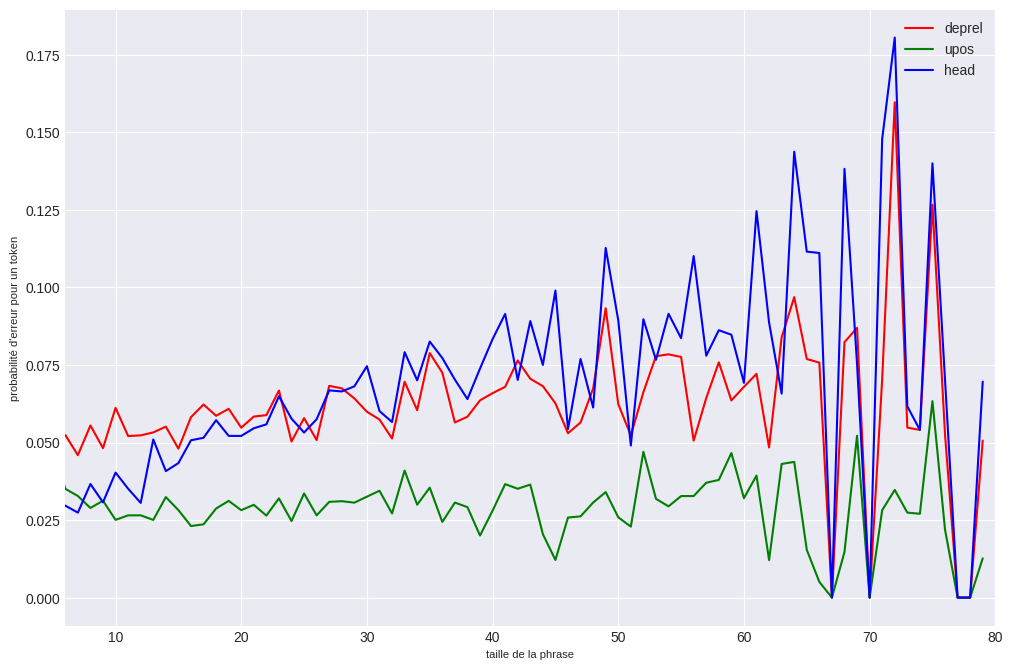

In [37]:
# Essayons de mettre tout ça dans un graphique
# On va plotter les ratio d'echec (1 - ratio_reussite) ça sera plus visuel
# Dans un même graphique on va plotter les 3 ratios : upos, deprel, head

colors = ["red", "green", "blue", "orange"]

x_lim = [5, 80] # on ne prend pas en compte les phrases de moins de 5 tokens et de plus de 80 tokens

plt.figure(figsize=(12,8))

for i, label in enumerate(["deprel", "upos", "head"]):
    x = list(range(x_lim[0], x_lim[1]))
    y = []
    for length in x:
        number_success = results_per_length.get(length, get_default_result())["success_{}".format(label)]
        number_total = results_per_length.get(length, get_default_result())["total_token"]
        
        fail_ratio = 0
        if number_total != 0:
            fail_ratio = (number_total - number_success) / number_total
        
        y.append(fail_ratio)

    plt.plot(range(x_lim[0], x_lim[1]), y, label=label, color=colors[i])

    # # si on veut afficher les approximations linéaires :
    # from sklearn.linear_model import LinearRegression
    # import numpy as np
    # regressor = LinearRegression()  
    # x = np.array(x).reshape(-1, 1)
    # y = np.array(y).reshape(-1, 1)
    # regressor.fit(x, y)
    # plt.plot(x, regressor.predict(x) ,color=colors[i], linestyle="dotted")

plt.xlabel("taille de la phrase")
plt.ylabel("probabilité d'erreur pour un token")
plt.legend()
plt.xlim([x_lim[0]+1,x_lim[1]])


- Est-ce que ces résultats étaient attendus ?
- À quel(s) biais devons nous faire attention ?

NB : Il faudrait utiliser des tests de significativité afin de prouver que les corrélations linéaires ne soient pas dû au hasard

## Erreurs de prédiction

In [44]:
# On récupère d'abord les listes des features réelles et prédites
gold_uposs = []
gold_deprels = []
gold_heads = []

pred_uposs = []
pred_deprels = []
pred_heads = []

for sentence in sentences:
    tokens = sentence["treeJson"]["nodesJson"].values()
    for token in tokens:
        gold_uposs.append(token['UPOS'])
        gold_deprels.append(token['DEPREL'])
        gold_heads.append(token['HEAD'])

        pred_uposs.append(token['MISC']['upos_pred'])
        pred_deprels.append(token['MISC']['deprel_pred'])
        pred_heads.append(token['MISC']['head_pred'])

set_uposs = set(gold_uposs)
set_deprels = set(gold_deprels)

## Erreurs de POS

In [53]:
# Quelles sont les plus grosses confusions de POS ?

# On va créer un dictionnaire qui va contenir pour chaque couple de POS, le nombre de fois où on a eu cette confusion
confusion_matrix_upos = {}

for gold_upos in set_uposs:
    confusion_matrix_upos[gold_upos] = {}
    for pred_upos in set_uposs:
        confusion_matrix_upos[gold_upos][pred_upos] = 0

for pred_upos, gold_upos in zip(pred_uposs, gold_uposs):
    confusion_matrix_upos[gold_upos][pred_upos] += 1

# # On trie le dictionnaire par ordre décroissant de nombre d'erreurs
# confusion_matrix_upos = sorted(confusion_matrix_upos.items(), key=lambda x: x[1], reverse=True)
# print(json.dumps(confusion_matrix_upos, indent=4))

In [54]:
confusion_matrix_upos

{'X': {'X': 374,
  'VERB': 12,
  'ADV': 2,
  'NUM': 0,
  'PUNCT': 1,
  'AUX': 1,
  'PART': 19,
  'DET': 6,
  'INTJ': 3,
  'PROPN': 5,
  'NOUN': 32,
  'ADP': 6,
  'PRON': 10,
  '_': 0,
  'CCONJ': 1,
  'SCONJ': 3,
  'ADJ': 7},
 'VERB': {'X': 4,
  'VERB': 16743,
  'ADV': 6,
  'NUM': 0,
  'PUNCT': 0,
  'AUX': 300,
  'PART': 2,
  'DET': 0,
  'INTJ': 0,
  'PROPN': 2,
  'NOUN': 188,
  'ADP': 28,
  'PRON': 2,
  '_': 0,
  'CCONJ': 0,
  'SCONJ': 2,
  'ADJ': 64},
 'ADV': {'X': 6,
  'VERB': 3,
  'ADV': 5631,
  'NUM': 0,
  'PUNCT': 0,
  'AUX': 2,
  'PART': 20,
  'DET': 1,
  'INTJ': 0,
  'PROPN': 0,
  'NOUN': 38,
  'ADP': 7,
  'PRON': 3,
  '_': 0,
  'CCONJ': 0,
  'SCONJ': 52,
  'ADJ': 31},
 'NUM': {'X': 0,
  'VERB': 0,
  'ADV': 0,
  'NUM': 1270,
  'PUNCT': 0,
  'AUX': 0,
  'PART': 0,
  'DET': 32,
  'INTJ': 0,
  'PROPN': 0,
  'NOUN': 17,
  'ADP': 0,
  'PRON': 4,
  '_': 0,
  'CCONJ': 0,
  'SCONJ': 0,
  'ADJ': 0},
 'PUNCT': {'X': 0,
  'VERB': 0,
  'ADV': 1,
  'NUM': 0,
  'PUNCT': 37169,
  'AUX': 0,
  '

# 